# Proyecto Final
Base de datos de .... sacada de: https://www.kaggle.com/datasets/phambacong/ieee-cis-fraud-detection

| Grupo de variables       | Rango/Columnas                  | Descripción general                                                                 |
|---------------------------|---------------------------------|-------------------------------------------------------------------------------------|
| Identificadores           | `TransactionID`, `TransactionDT` | ID único de la transacción y timestamp relativo (segundos desde inicio del dataset). |
| Transacción básica        | `TransactionAmt`, `ProductCD`    | Monto de la transacción y tipo de producto/código de categoría.                      |
| Tarjeta                   | `card1` – `card6`                | Información de la tarjeta utilizada (tipo, emisor, categoría, enmascarado).          |
| Dirección                 | `addr1`, `addr2`                 | Información parcial de dirección/postal relacionada al usuario.                      |
| Distancias                | `dist1`, `dist2`                 | Distancias geográficas aproximadas entre direcciones (billing/shipping).             |
| Variables de cuenta       | `P_emaildomain`, `R_emaildomain` | Dominios de correo del pagador y receptor.                                           |
| Identidad                 | `id_01` – `id_38`                | Características de dispositivo, navegador, dirección IP, etc. (anonimizadas).        |
| Conteos                   | `C1` – `C14`                     | Features de tipo “count”, agregados estadísticos de comportamiento (anonimizados).   |
| Diferencias temporales    | `D1` – `D15`                     | Diferencias de tiempo (ej. días desde transacciones anteriores, anonimizados).       |
| Flags de coincidencia     | `M1` – `M9`                      | Variables binarias/categóricas que indican si ciertos datos coinciden (billing/shipping, email, etc.). |
| Features derivados (Vesta)| `V1` – `V339`                    | Conjunto masivo de variables creadas por Vesta: métricas de riesgo, patrones, ratios, etc. (anonimizados). |
| Etiqueta                  | `isFraud`                        | Variable objetivo: 1 si la transacción es fraudulenta, 0 si es legítima.             |


## Imports generales y funciones de ayuda.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV3
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from collections import Counter

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

data_path = './train.csv'
data = pd.read_csv(data_path)

if "Unnamed: 0" in data.columns:
    transactions = data.drop(["Unnamed: 0"], axis=1)
elif "Unnamed" in data.columns:
    transactions = data.drop(["Unnamed"], axis=1)


def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        
        if np.issubdtype(col_type, np.datetime64):
                continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    return df

def summary(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values

    return summary

print("Importaciones finalizadas.")

Importaciones finalizadas.


## Exploración y optimización de los datos

Forma de las Características (Features): (590540, 435)
Forma de las Etiquetas (Labels): (590540,)

Primeras 5 filas del DataFrame:
   Unnamed: 0  TransactionID_x  isFraud  TransactionDT  TransactionAmt  \
0           0          2987000        0          86400            68.5   
1           1          2987001        0          86401            29.0   
2           2          2987002        0          86469            59.0   
3           3          2987003        0          86499            50.0   
4           4          2987004        0          86506            50.0   

   ProductCD  card1  card2  card3  card4  ...  id_31  id_32  id_33  id_34  \
0          4  13926  321.0  150.0      1  ...    123   32.0    164      3   
1          4   2755  404.0  150.0      2  ...     98   32.0     48      2   
2          4   4663  490.0  150.0      3  ...     44   24.0    132      3   
3          4  18132  567.0  150.0      2  ...     44   24.0    132      3   
4          1   4497  514.0  150.0      

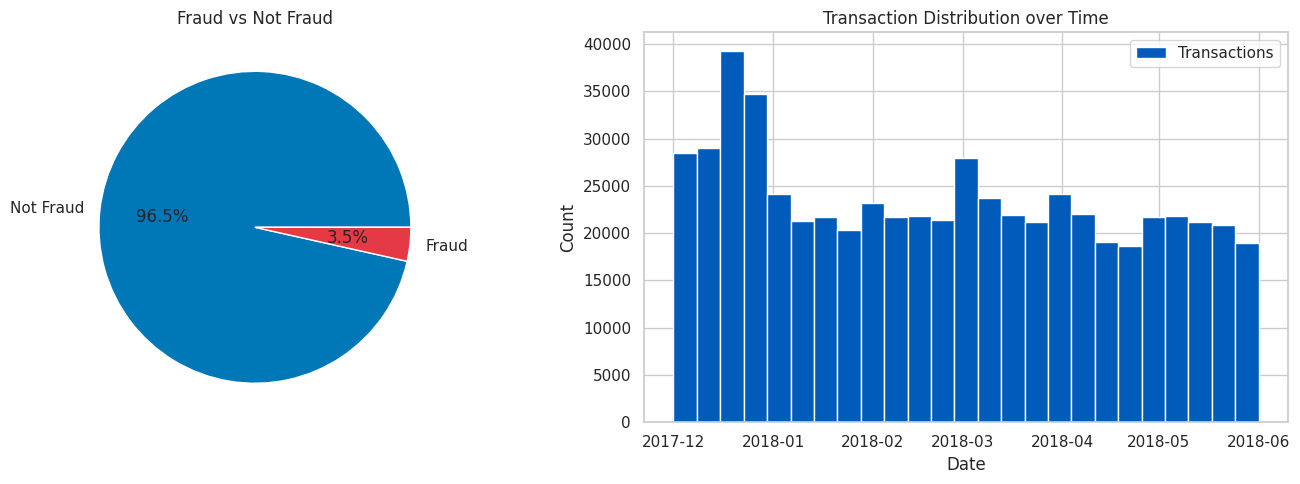


Conteo de clases: Counter({np.int8(0): 569877, np.int8(1): 20663})
Unnamed: 0         0.0
TransactionID_x    0.0
isFraud            0.0
TransactionDT      0.0
TransactionAmt     0.0
ProductCD          0.0
card1              0.0
card2              0.0
card3              0.0
card4              0.0
card5              0.0
card6              0.0
addr1              0.0
addr2              0.0
dist1              0.0
dist2              0.0
P_emaildomain      0.0
R_emaildomain      0.0
C1                 0.0
C2                 0.0
dtype: float64
Series([], dtype: float64)


In [2]:
data_reduced = reduce_mem_usage(data).copy()
del data

labels = data_reduced['isFraud'].values
features = data_reduced.drop(['isFraud'], axis=1).values


print('Forma de las Características (Features):', features.shape)
print('Forma de las Etiquetas (Labels):', labels.shape)
print('\nPrimeras 5 filas del DataFrame:')
print(data_reduced.head())

start_date = pd.to_datetime("2017-11-30")

# Convertimos TransactionDT en fecha real
data_reduced['TransactionDate'] = start_date + pd.to_timedelta(data_reduced['TransactionDT'], unit='s')

# Gráfico de clases

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].pie(
    data_reduced.isFraud.value_counts(), 
    labels=['Not Fraud', 'Fraud'], 
    autopct='%0.1f%%', 
    colors=['#0077b6', '#e63946']
)
axes[0].set_title("Fraud vs Not Fraud")

# Gráfico temporal
axes[1].hist(
    data_reduced['TransactionDate'], 
    bins=25, 
    color="#005BBB", 
    label='Transactions'
)
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Date')
axes[1].set_title('Transaction Distribution over Time')
axes[1].legend()

plt.tight_layout()
plt.show()



print("\nConteo de clases:", Counter(labels))


missing = data_reduced.isnull().mean().sort_values(ascending=False)
print(missing.head(20))


categorical_cols = data_reduced.select_dtypes(include=['object']).columns
print(data_reduced[categorical_cols].nunique().sort_values(ascending=False).head(20))


### Descubrimientos sobre los datos:
Tenemos una base muy robusta de transacciones en un rango aproximado de 6 meses, son muchas y por temas de seguridad muchas de las caracteristicas que guardan sobre cada una de las transacciones son redactadas, no tenemos una descripcion de que significan la gran mayoría de las caracteristicas de nuestro dataset, pero sin embargo podemos estar seguros que cuando llegue una nueva transacción, van a tomar estas mismas caracteristicas, por lo que de igual manera nos sirve para generar un modelo que nos ayude a dicernir si una transacción es real o es un fraudulenta. Sin embargo las conclusiones que tomemos sobre este dataset serán probablemente muy abstractas, vamos a entender las caracteristicas especificas que hacen una transaccion fraudulenta pero no vamos a saber ver estas caracteristicas en la vida cotidiana.
Cómo tenemos tantos datos, es computacionalmente 

In [3]:
zero_threshold = 0.7
zero_pct = np.mean(features == 0, axis=0)

cols_to_drop_zeros = np.where(zero_pct > zero_threshold)[0].tolist()
features_filtered = np.delete(features, cols_to_drop_zeros, axis=1)

print(f"Columnas con > {zero_threshold*100}% de ceros: {len(cols_to_drop_zeros)}")

print('Forma de las Características despues del drop 1:', features_filtered.shape)

low_variance_cols = []
for i in range(features_filtered.shape[1]):
    col = features_filtered[:, i]
    if len(np.unique(col)) == 1:
        low_variance_cols.append(i)
    elif np.std(col) / (np.mean(col) + 1e-10) < 0.01:
        low_variance_cols.append(i)

features_filtered2 = np.delete(features_filtered, low_variance_cols, axis=1)

print(f"Columnas con baja varianza: {len(low_variance_cols)}")
print('Forma de las Características despues del drop 2:', features_filtered2.shape)

corr_matrix = np.corrcoef(features_filtered, rowvar=False)
upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)

high_corr_cols = []
for j in range(corr_matrix.shape[1]):
    if any(corr_matrix[i, j] > 0.95 for i in range(j)):
        high_corr_cols.append(j)


features_filtered2 = np.delete(features_filtered2, high_corr_cols, axis=1)
print(f"Columnas altamente correlacionadas: {len(high_corr_cols)}")
print('Forma de las Características despues del drop 3:', features_filtered2.shape)


Columnas con > 70.0% de ceros: 226
Forma de las Características despues del drop 1: (590540, 209)
Columnas con baja varianza: 7
Forma de las Características despues del drop 2: (590540, 202)
Columnas altamente correlacionadas: 31
Forma de las Características despues del drop 3: (590540, 171)


In [4]:
X_temp, X_unused, y_temp, y_unused = train_test_split(
    features_filtered2,
    labels,
    test_size=0.95,   # dejamos fuera el 65% para quedarnos con el 35%
    random_state=42,
    stratify=labels
)

# Ahora separamos dentro de ese 35% el 30% y 5%
X_train, X_test, y_train, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.2,   # 5 de 35 ≈ 14.3% de ese subset
    random_state=42,
    stratify=y_temp
)

print('Forma de X_train:', X_train.shape)
print('Forma de X_test:', X_test.shape)
print('Distribución en y_train:', Counter(y_train))
print('Distribución en y_test:', Counter(y_test))

Forma de X_train: (23621, 171)
Forma de X_test: (5906, 171)
Distribución en y_train: Counter({np.int8(0): 22795, np.int8(1): 826})
Distribución en y_test: Counter({np.int8(0): 5699, np.int8(1): 207})


In [5]:
from imblearn.pipeline import Pipeline as ImbPipeline

# --- PARÁMETROS PARA GridSearchCV ---
param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20],
}
param_grid_svc = {
    'model__C': [1, 10],
    'model__kernel': ['rbf']
}
param_grid_gb = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.05, 0.1],
}

# --- DICCIONARIO DE MODELOS ---
models = {
    'Random Forest': (RandomForestClassifier(random_state=42), param_grid_rf),
    'SVC': (SVC(random_state=42, probability=True), param_grid_svc),
    'Gradient Boosting': (GradientBoostingClassifier(random_state=42), param_grid_gb)
}

# --- DICCIONARIO PARA ALMACENAR RESULTADOS ---
results = {}

# --- BUCLE PRINCIPAL DE EXPERIMENTACIÓN  ---
preproc_steps = {
    "Original": [],
    "Scaler": [('scaler', StandardScaler())],
    "PCA": [('pca', PCA(n_components=0.95))],
    "Scaler_PCA": [('scaler', StandardScaler()), ('pca', PCA(n_components=0.95))]
}

for preproc_name, preproc_list in preproc_steps.items():
    print(f"================== ESTRATEGIA: {preproc_name} ==================")

    # Aplicar preprocesamiento solo al conjunto de test una vez
    X_train_proc, X_test_proc = X_train, X_test
    if preproc_list:
        preproc_pipeline = ImbPipeline(steps=preproc_list)
        X_train_proc = preproc_pipeline.fit_transform(X_train)
        X_test_proc = preproc_pipeline.transform(X_test)

    for model_name, (model, params) in models.items():
        # --- Escenario SIN Balanceo ---
        print(f"\n--- Entrenando {model_name} (Sin Balanceo) ---")
        pipeline_no_balance = ImbPipeline(steps=preproc_list + [('model', model)])

        # Ajustamos los nombres de los parámetros para que coincidan con el pipeline
        search_params_no_balance = {k: v for k, v in params.items()}

        grid_search = GridSearchCV(pipeline_no_balance, search_params_no_balance, cv=3, n_jobs=-1, scoring='accuracy', verbose=0)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)


        accuracy = accuracy_score(y_test, y_pred)
        key = f"{preproc_name} + Sin Balanceo + {model_name}"
        results[key] = accuracy
        print(f"Accuracy en Test: {accuracy:.4f}")

        # --- Escenario CON Balanceo (SMOTE) ---
        print(f"--- Entrenando {model_name} (Con SMOTE) ---")

        # Creamos el pipeline que incluye SMOTE
        pipeline_with_balance = ImbPipeline(steps=[
            *preproc_list,
            ('smote', SMOTE(random_state=42, sampling_strategy=0.3)),
            ('model', model)
        ])

        search_params_balance = {k: v for k, v in params.items()}

        grid_search_smote = GridSearchCV(pipeline_with_balance, search_params_balance, cv=3, n_jobs=-1, scoring='accuracy', verbose=0)
        grid_search_smote.fit(X_train, y_train)
        best_model_smote = grid_search_smote.best_estimator_
        y_pred_smote = best_model_smote.predict(X_test)

        accuracy_smote = accuracy_score(y_test, y_pred_smote)
        key_smote = f"{preproc_name} + Con SMOTE + {model_name}"
        results[key_smote] = accuracy_smote
        print(f"Accuracy en Test: {accuracy_smote:.4f}")

================== ESTRATEGIA: Original ==================

--- Entrenando Random Forest (Sin Balanceo) ---
Accuracy en Test: 0.9710
--- Entrenando Random Forest (Con SMOTE) ---
Accuracy en Test: 0.9717

--- Entrenando SVC (Sin Balanceo) ---
Accuracy en Test: 0.9650
--- Entrenando SVC (Con SMOTE) ---
Accuracy en Test: 0.9650

--- Entrenando Gradient Boosting (Sin Balanceo) ---
Accuracy en Test: 0.9722
--- Entrenando Gradient Boosting (Con SMOTE) ---
Accuracy en Test: 0.9719
================== ESTRATEGIA: Scaler ==================

--- Entrenando Random Forest (Sin Balanceo) ---
Accuracy en Test: 0.9710
--- Entrenando Random Forest (Con SMOTE) ---
Accuracy en Test: 0.9724

--- Entrenando SVC (Sin Balanceo) ---
Accuracy en Test: 0.9678
--- Entrenando SVC (Con SMOTE) ---
Accuracy en Test: 0.9612

--- Entrenando Gradient Boosting (Sin Balanceo) ---
Accuracy en Test: 0.9722
--- Entrenando Gradient Boosting (Con SMOTE) ---
Accuracy en Test: 0.9719
================== ESTRATEGIA: PCA =========

## Interpretación de nuestro dataset:
Tenemos n características y un total de m entradas, 
Ya separamos nuestro target 'isFraud' del dataframe de los features. También hemos depurado un poco los features ya que hay caracteristicas que tienen demasiada correlación entre sí y al final no nos dan información nueva 
Para empezar, si queremos encontrar el mejor fit para nuestros datos no pudemos utilizar el tamaño completo, ya que es computacionalmente muy desgastante, lo que podemos hacer 